<a href="https://colab.research.google.com/github/gupta24789/hugging_face/blob/main/fine_tune_distilbert_for_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q transformers
!pip install -U -q accelerate
!pip install -U -q datasets
!pip install -U -q bertviz
!pip install -U -q umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
from datasets import load_dataset, list_datasets
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

import torch
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer

In [3]:
all_datasets = list_datasets()
print(f"#available datasets : {len(all_datasets)}")
print(f"sample datasets : {all_datasets[:3]}")

<ipython-input-3-55ead17a12fd>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


#available datasets : 93025
sample datasets : ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa']


In [4]:
## Load dataset
emotion = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [5]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
## set the format of data
emotion.set_format(type='pandas')

In [7]:
## Available classes in the data
classes = emotion['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [8]:
df = emotion['train'][:]

In [9]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
df['label_name'] = df.label.apply(lambda x: classes[x])

In [11]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Data Exploration

In [12]:
## Inference : Imblanced dataset
df.label_name.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label_name, dtype: int64

<Axes: >

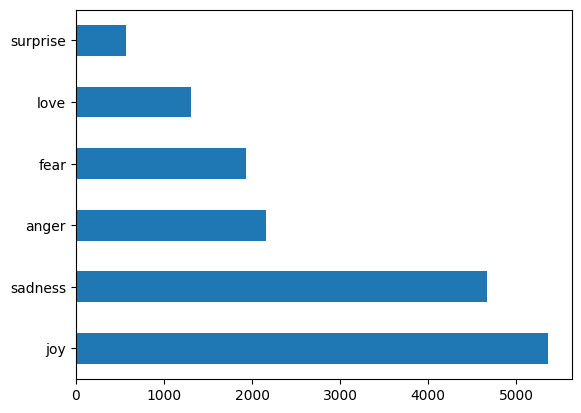

In [13]:
df.label_name.value_counts().plot(kind = 'barh')

In [14]:
df["words_per_tweet"] = df.text.str.split(' ').str.len()

<Axes: title={'center': 'words_per_tweet'}, xlabel='label_name'>

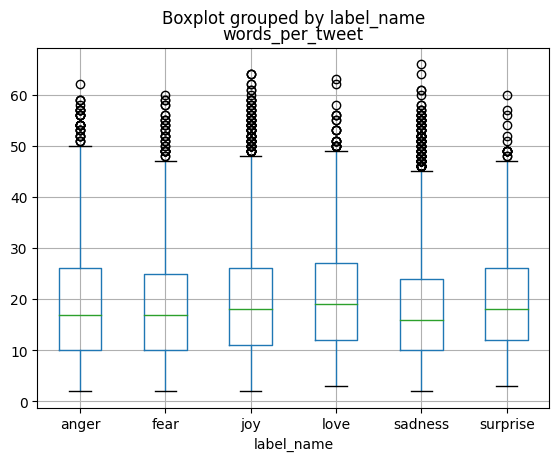

In [15]:
df.boxplot("words_per_tweet", by = 'label_name')

In [16]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Vocab size : {tokenizer.vocab_size}, model max length  : {tokenizer.model_max_length}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Vocab size : 30522, model max length  : 512


In [17]:
sample_tweet = "I love Machine Learning!. Tokenization is awesome"
encoded_text = tokenizer(sample_tweet)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 1012, 19204, 3989, 2003, 12476, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## Spceial Tokens

  - [CLS]:  101 : start of sentence
  - [SEP]: 102 :  end of senetence

In [18]:
## convert token ids to tokens
print(tokenizer.convert_ids_to_tokens(encoded_text['input_ids']))

['[CLS]', 'i', 'love', 'machine', 'learning', '!', '.', 'token', '##ization', 'is', 'awesome', '[SEP]']


In [19]:
## another way to get the tokens
print(encoded_text.tokens())

['[CLS]', 'i', 'love', 'machine', 'learning', '!', '.', 'token', '##ization', 'is', 'awesome', '[SEP]']


In [20]:
## reset format
emotion.reset_format()

## Tokenized Data

In [21]:
emotion["train"][:2]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
 'label': [0, 0]}

In [22]:
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize(emotion["train"][:1]))
print(tokenize(emotion["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}
{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [23]:
emotion_encoded = emotion.map(tokenize, batched = True, batch_size = None)

In [24]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

## Model Building

In [25]:
model = AutoModel.from_pretrained(model_name)

In [26]:
print(sample_tweet)
inputs = tokenizer(sample_tweet, return_tensors='pt')
inputs

I love Machine Learning!. Tokenization is awesome


{'input_ids': tensor([[  101,  1045,  2293,  3698,  4083,   999,  1012, 19204,  3989,  2003,
         12476,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [27]:
with torch.no_grad():
  outputs = model(**inputs)
  print(outputs.keys())

last_hidden_state = outputs.last_hidden_state
print(f"shape : {last_hidden_state.shape}")

odict_keys(['last_hidden_state'])
shape : torch.Size([1, 12, 768])


## Fine-Tuning Transformers

In [28]:
num_labels = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
batch_size = 64
fine_tuned_model_name = "distilbert-finetuned-emotion"

training_args = TrainingArguments(output_dir = fine_tuned_model_name,
                                 num_train_epochs=2,
                                 learning_rate = 2e-5,
                                 per_device_train_batch_size= batch_size,
                                 per_device_eval_batch_size = batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm=False)

In [31]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [32]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotion_encoded['train'],
                  eval_dataset=emotion_encoded['validation'],
                  tokenizer=tokenizer)

In [33]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.296411,0.911000,0.910411
2,0.518000,0.208678,0.927000,0.927131


TrainOutput(global_step=500, training_loss=0.518030029296875, metrics={'train_runtime': 234.1975, 'train_samples_per_second': 136.637, 'train_steps_per_second': 2.135, 'total_flos': 720342861696000.0, 'train_loss': 0.518030029296875, 'epoch': 2.0})

In [34]:
preds_outputs = trainer.predict(emotion_encoded['test'])
preds_outputs.metrics

{'test_loss': 0.21154329180717468,
 'test_accuracy': 0.9185,
 'test_f1': 0.9181040318345289,
 'test_runtime': 3.812,
 'test_samples_per_second': 524.658,
 'test_steps_per_second': 8.395}

In [35]:
import numpy as np
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [36]:
from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.94      0.94      0.94       695
           2       0.77      0.82      0.80       159
           3       0.93      0.92      0.93       275
           4       0.89      0.89      0.89       224
           5       0.78      0.64      0.70        66

    accuracy                           0.92      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [40]:
text = 'i want to kill you'
input_encoded = tokenizer(text, return_tensors='pt').to(device)
with torch.no_grad():
  outputs = model(**input_encoded)
  print("outputs : ",outputs)

logits = outputs.logits
print("logits : ",logits.shape)
pred = torch.argmax(logits, dim=1).item()
pred, classes[pred]

outputs :  SequenceClassifierOutput(loss=None, logits=tensor([[ 0.4414, -0.3940, -1.4527,  2.7489, -0.2480, -1.9007]],
       device='cuda:0'), hidden_states=None, attentions=None)
logits :  torch.Size([1, 6])


(3, 'anger')